In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.lib.histograms import histogram
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
silver = pd.read_csv("silver_data.csv")

#removing games ended in early surrender
silver = silver[silver['gameDurationMinutes'] > 15]



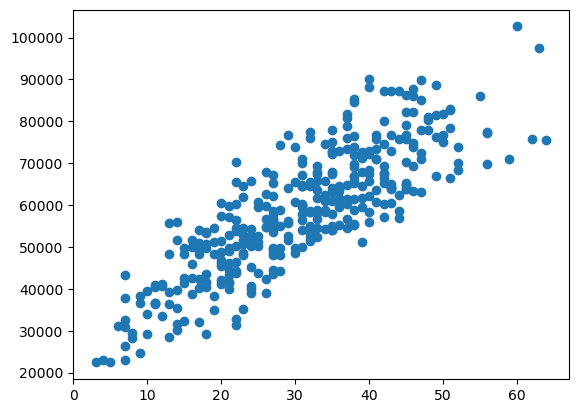

In [3]:
plt.scatter(silver['totalKills'], silver['totalGold'])
plt.show()

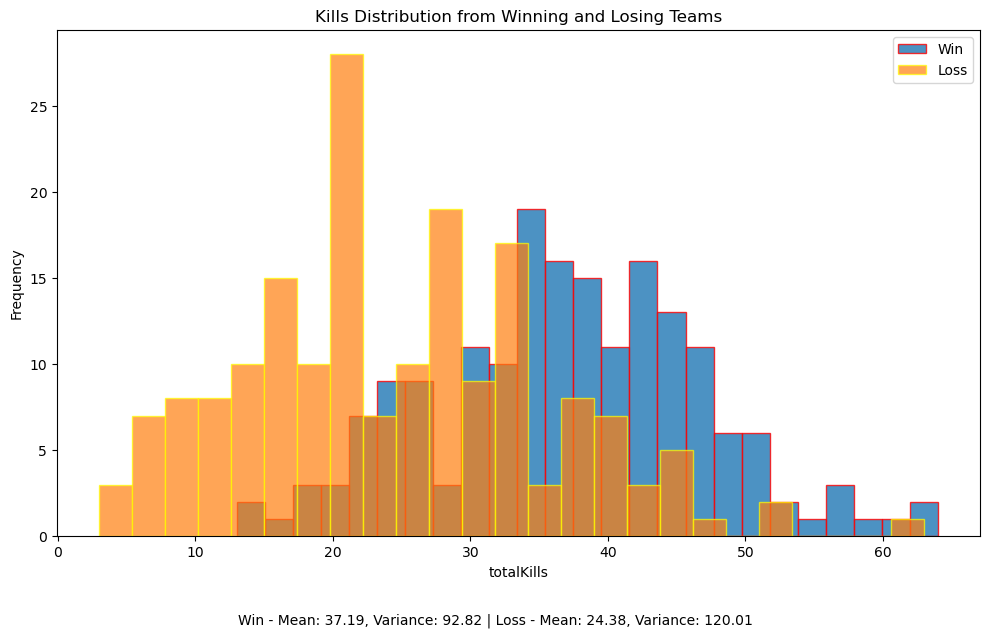

In [4]:

# Calculate summary statistics
win_kills = silver[silver['win'] == True]['totalKills']
loss_kills = silver[silver['win'] == False]['totalKills']

win_mean = win_kills.mean()
win_var = win_kills.var()

loss_mean = loss_kills.mean()
loss_var = loss_kills.var()

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(win_kills, label="Win", bins=25, alpha=0.8, edgecolor='red')
plt.hist(loss_kills, label="Loss", bins=25, alpha=0.7, edgecolor='yellow')

# Labels and title
plt.xlabel('totalKills')
plt.ylabel('Frequency')
plt.title('Kills Distribution from Winning and Losing Teams')
plt.legend()

# Add summary statistics below the plot
plt.figtext(0.5, -0.05, 
            f"Win - Mean: {win_mean:.2f}, Variance: {win_var:.2f} | "
            f"Loss - Mean: {loss_mean:.2f}, Variance: {loss_var:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


<Axes: >

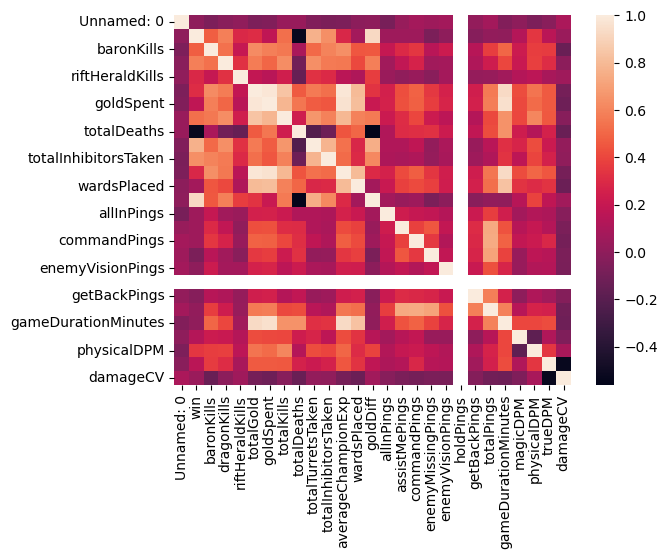

In [5]:
silver_heat = silver.drop(columns=['matchId', 'teamId', 'mid', 'top', 'jung', 'bot', 'sup', 'midItems', 'topItems', 
                                   'jungItems', 'botItems', 'supItems'])
sns.heatmap(silver_heat.corr())


In [6]:
silverWinCV = silver[silver['win'] == True]['magicDPM']
silverLoseCV = silver[silver['win'] == False]['magicDPM']
print(silverWinCV.mean(), silverLoseCV.mean())


1648.7470465816175 1494.5900679446718


Building Random Forest Model for predicting win outcomes

Accuracy: 0.726027397260274

Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.68      0.71        37
        True       0.70      0.78      0.74        36

    accuracy                           0.73        73
   macro avg       0.73      0.73      0.73        73
weighted avg       0.73      0.73      0.73        73


Confusion Matrix:
 [[25 12]
 [ 8 28]]


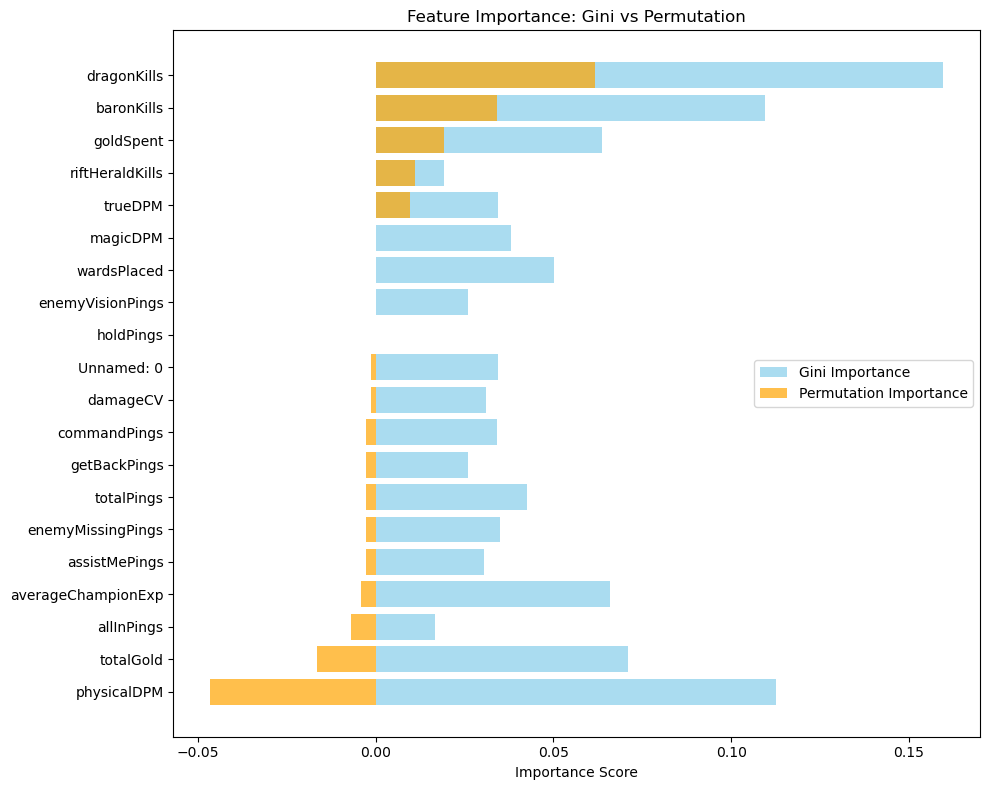

In [7]:
# load data
silver_df = pd.read_csv('silver_data.csv')
silver_df = silver_df[(silver_df['gameDurationMinutes'] > 15)]


# Define features (X) and target (y)
X = silver_df.drop(columns = ['win', "totalInhibitorsTaken", "totalTurretsTaken", "totalKills",'matchId', 'teamId', "topItems", "midItems", "jungItems", "supItems", "botItems", "mid", "top", "jung", "bot", "sup", "goldDiff", "totalDeaths", "gameDurationMinutes"])
y = silver_df['win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance
)

# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Gini-based (built-in)
gini_df = pd.DataFrame({
    'Feature': X.columns,
    'Gini Importance': model.feature_importances_
})

# Permutation importance
perm_result = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance': perm_result.importances_mean,
    'Permutation Std': perm_result.importances_std
})

# Merge side-by-side
comparison_df = gini_df.merge(perm_df, on='Feature')
comparison_df = comparison_df.sort_values(by='Permutation Importance', ascending=False)

# --- Gini-based importance ---
gini_df = pd.DataFrame({
    'Feature': X.columns,
    'Gini Importance': model.feature_importances_
})

# --- Permutation importance ---
perm_result = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance': perm_result.importances_mean,
    'Permutation Std': perm_result.importances_std
})

# --- Merge ---
comparison_df = gini_df.merge(perm_df, on='Feature')

# --- Sort by Permutation Importance for display ---
comparison_df = comparison_df.sort_values(
    by='Permutation Importance',
    ascending=True
)  # ascending for horizontal bar plot

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 8))

# Horizontal bars for Gini importance
ax.barh(
    comparison_df['Feature'],
    comparison_df['Gini Importance'],
    color='skyblue',
    alpha=0.7,
    label='Gini Importance'
)

# Horizontal bars for Permutation importance (overlay slightly)
ax.barh(
    comparison_df['Feature'],
    comparison_df['Permutation Importance'],
    color='orange',
    alpha=0.7,
    label='Permutation Importance'
)

ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance: Gini vs Permutation")
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
print(X_train.columns)

Index(['Unnamed: 0', 'baronKills', 'dragonKills', 'riftHeraldKills',
       'totalGold', 'goldSpent', 'averageChampionExp', 'wardsPlaced',
       'allInPings', 'assistMePings', 'commandPings', 'enemyMissingPings',
       'enemyVisionPings', 'holdPings', 'getBackPings', 'totalPings',
       'magicDPM', 'physicalDPM', 'trueDPM', 'damageCV'],
      dtype='object')


In [80]:
silver_df

,Unnamed: 0,matchId,teamId,win,baronKills,dragonKills,riftHeraldKills,totalGold,goldSpent,totalKills,...,mid,midItems,bot,botItems,sup,supItems,magicDPM,physicalDPM,trueDPM,damageCV
0,0,NA1_5217191498,100,True,0,2,0,40399,36225,18,...,Mel,"[6653, 2031, 6655, 3020, 0, 0, 3340]",Tristana,"[1055, 3032, 3172, 6675, 3123, 3035, 3363]",Seraphine,"[3870, 3040, 3009, 3067, 1004, 2055, 3364]",1056.357447,1618.110638,37.582979,0.886267
1,1,NA1_5217191498,200,False,0,0,0,30238,27150,14,...,Malzahar,"[2503, 1056, 3147, 3020, 0, 1052, 3340]",Jinx,"[1055, 3032, 3006, 0, 2003, 0, 3340]",Soraka,"[3869, 2031, 6617, 1028, 1029, 1001, 3364]",1251.319149,981.446809,79.148936,0.796562
2,2,NA1_5217177369,100,False,0,1,0,46430,44275,22,...,Veigar,"[3040, 6657, 3020, 3145, 0, 1058, 3340]",Samira,"[1055, 2031, 6676, 3047, 3031, 1036, 3363]",JarvanIV,"[3084, 3190, 3869, 3047, 1028, 1029, 3364]",2025.791457,1427.261307,127.010050,0.813473
3,3,NA1_5217177369,200,True,0,3,1,54989,45700,35,...,Aatrox,"[6699, 3161, 1001, 1055, 0, 0, 3340]",Jinx,"[1055, 3172, 3139, 6672, 3032, 1038, 3363]",Seraphine,"[3870, 3107, 3040, 0, 3009, 0, 3364]",923.781407,3500.427136,126.896985,1.162317
4,4,NA1_5216073893,100,True,2,4,1,81806,73735,50,...,Ekko,"[3089, 4630, 3041, 3171, 3100, 3115, 3364]",MissFortune,"[6676, 3814, 3170, 3142, 6694, 3133, 3340]",Swain,"[3876, 3076, 3170, 6653, 2503, 3116, 3364]",1488.092910,2178.679707,369.119804,0.678803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,55,NA1_5331095955,200,False,0,0,0,64912,62158,31,...,Akali,"[1054, 3100, 3157, 4645, 3020, 4630, 3340]",Aphelios,"[1055, 6676, 6670, 3036, 3031, 3009, 3363]",Lulu,"[3107, 2065, 3222, 3870, 2055, 3158, 3364]",1312.368421,1801.198830,128.216374,0.796077
372,56,NA1_5331008259,100,True,1,2,1,76473,63883,38,...,Yasuo,"[6672, 6333, 3047, 6673, 3033, 1053, 3363]",Aphelios,"[3033, 1055, 3006, 6676, 3031, 6670, 3363]",Soraka,"[3869, 3067, 3013, 3107, 6617, 2055, 3364]",556.129032,2856.521739,265.441795,1.157807
373,57,NA1_5331008259,200,False,1,3,0,67214,64243,27,...,Zed,"[3134, 6694, 2021, 6699, 3171, 6692, 3364]",Xayah,"[3032, 3072, 1055, 3006, 0, 3031, 3363]",Rell,"[3869, 3190, 2055, 3174, 3076, 3050, 3364]",1176.970547,2157.755961,301.290323,0.766274
374,58,NA1_5330993404,100,True,2,4,1,73828,67103,38,...,Ekko,"[3089, 3157, 3115, 3020, 4645, 3100, 3340]",Jhin,"[6676, 3142, 3009, 3031, 3036, 0, 3363]",Nami,"[3870, 2065, 4005, 6620, 3158, 0, 3364]",1268.795970,1702.337531,413.350126,0.581389
